# Assignment 2 2AMM10 2023-2024

## Group: [Shash_Kas_Pim]
### Member 1: [Shashank Prabhu]
### Member 2: [Kasra Gheytuli]
### Member 3: [Pim de Wildt]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [19]:
!pip show torch

Name: torch
Version: 2.7.0+cu128
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\shash\OneDrive - TU Eindhoven\Shashank Prabhu University\Masters DSAI\Q4\2AMM10 Deep Learning\2AMM10-Assignments\venv\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision


In [20]:
# !pip install rdkit
# !pip install torch_geometric
# !pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

In [21]:
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt

In [22]:
dir_add = 'ass2_data/'

with open(dir_add+'pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open(dir_add+'type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open(dir_add+'smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load(dir_add+'data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load(dir_add+'formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

In [23]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 119012, test: 10000, sum: 129012


In [24]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


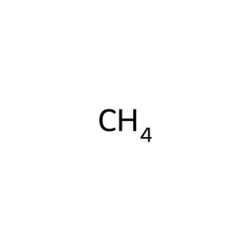

In [25]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.241│     1.621│    -0.131
  C  │  6   │     0.014│     0.122│    -0.039
  C  │  6   │     1.171│    -0.587│    -0.816
  C  │  6   │     2.435│     0.094│    -0.260
  C  │  6   │     2.081│     0.077│     1.271
  O  │  8   │     2.019│     1.352│     1.891
  C  │  6   │     0.693│    -0.569│     1.193
  C  │  6   │     1.015│    -1.753│     0.215
  O  │  8   │     0.024│    -2.723│    -0.005
  H  │  1   │     0.642│     2.211│     0.114
  H  │  1   │    -0.578│     1.887│    -1.140
  H  │  1   │    -1.031│     1.916│     0.568
  H  │  1   │    -0.933│    -0.387│    -0.256
  H  │  1   │     1.120│    -0.765│    -1.892
  H  │  1   │     3.345│    -0.470│    -0.488
  H  │  1   │     2.566│     1.118│    -0.619
  H  │  1   │     2.772│    -0.570│     1.831
  H  │  1   │     2.912│     1.712│     1.918
  H  │  1   │     0.171│    -0.730│     2.137
  H  │  1   │     1.924│    -2.322

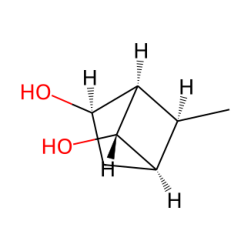

In [26]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.data import Data, DataLoader as GeometricDataLoader
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import Ridge

import numpy as np
import pickle
import time
import math
import os

from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
import rdkit.DataStructs as DataStructs
RDLogger.DisableLog('rdApp.*')

import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.auto import tqdm

c:\Users\shash\OneDrive - TU Eindhoven\Shashank Prabhu University\Masters DSAI\Q4\2AMM10 Deep Learning\2AMM10-Assignments\venv\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\shash\OneDrive - TU Eindhoven\Shashank Prabhu University\Masters DSAI\Q4\2AMM10 Deep Learning\2AMM10-Assignments\venv\Lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\shash\OneDrive - TU Eindhoven\Shashank Prabhu University\Masters DSAI\Q4\2AMM10 Deep Learning\2AMM10-Assignments\venv\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disablin

### GNN

In [28]:
#GNN

class GNNMessagePassing(MessagePassing):
    '''
    Custom message passing layer implementing:
    x_i^(k) = γ^k(x_i^(k-1), ⋃_{j∈N(i)} φ^k(x_i^(k-1), x_j^(k-1), e_{j,i}))
    
    - φ^k: Edge transfer function (processes bond information)
    - γ^k: Node update function (updates atom representations)
    - ⋃: Message aggregation (mean aggregation for stability)

    REF LEC 3
    '''
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super().__init__(aggr='mean') #using mean aggregation
        
        # Edge transfer function
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Node update function
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim)
        )
        
        self.layer_norm = nn.LayerNorm(node_dim)
        
    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)
    
    def message(self, x_i, x_j, edge_attr):
        edge_input = torch.cat([x_i, x_j, edge_attr], dim=-1)
        return self.edge_mlp(edge_input)
    
    def update(self, aggr_out, x):
        node_input = torch.cat([x, aggr_out], dim=-1)
        h = self.node_mlp(node_input)
        return self.layer_norm(h + x)  # Skip connection + normalization


class MolecularGNN(nn.Module):
    '''
    Complete GNN architecture for molecular property prediction.
    Respects molecular symmetries through distance-based features.
    '''
    def __init__(self, num_atom_types=20, hidden_dim=128, num_layers=3):
        super().__init__()
        
        self.atom_embedding = nn.Embedding(num_atom_types, hidden_dim)
        self.input_projection = nn.Linear(hidden_dim + 3, hidden_dim)
        
        self.mp_layers = nn.ModuleList([
            GNNMessagePassing(hidden_dim, 1, hidden_dim)
            for _ in range(num_layers)
        ])
        
        self.output_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def compute_edge_features(self, pos, edge_index): 
        #for invariance - bond length remains invariant under rotation and translation invarance as ditance is invariant under translation
        '''Compute rotation-invariant distance features'''
        row, col = edge_index
        distances = torch.norm(pos[row] - pos[col], dim=1, keepdim=True)
        return distances
    
    def forward(self, batch_data):
        x = batch_data.x
        pos = batch_data.pos
        edge_index = batch_data.edge_index
        batch = batch_data.batch
        
        # Embed atoms and combine with positions
        atom_features = self.atom_embedding(x)
        node_features = torch.cat([atom_features, pos], dim=-1)
        node_features = self.input_projection(node_features)
        
        # Compute edge features
        edge_features = self.compute_edge_features(pos, edge_index)
        
        # Message passing with skip connections
        for i, mp_layer in enumerate(self.mp_layers):
            if i > 0:
                node_features = node_features + mp_layer(node_features, edge_index, edge_features)
            else:
                node_features = mp_layer(node_features, edge_index, edge_features)
        
        # Global pooling
        graph_features = global_mean_pool(node_features, batch)
        
        return self.output_mlp(graph_features)

In [29]:
#Data pre proocessing (to add edges for a geometric representation)
def create_molecular_graph(positions, atom_types, threshold=2.5): #2.5 Angstroms is a common threshold for covalent bonds
    '''
    Create PyTorch Geometric graph from molecular data.
    Connects atoms within threshold distance.
    '''
    num_atoms = len(atom_types)
    positions = np.array(positions)
    
    # Create edges based on distance
    edges = []
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist < threshold:
                edges.append([i, j])
                edges.append([j, i])
    
    # Fallback: fully connected if no edges
    if not edges:
        edges = [[i, j] for i in range(num_atoms) for j in range(num_atoms) if i != j]
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    return Data(
        x=torch.tensor(atom_types, dtype=torch.long),
        pos=torch.tensor(positions, dtype=torch.float),
        edge_index=edge_index
    )

#Dataset class and loaders
class GeometricDataset(Dataset):
    '''PyTorch dataset for geometric molecular data'''
    def __init__(self, pos_data, type_data, targets, indices, threshold=2.5):
        self.graphs = []
        print(f"Creating {len(indices)} molecular graphs with threshold={threshold}...")
        for idx in tqdm(indices):
            graph = create_molecular_graph(pos_data[idx], type_data[idx], threshold)
            graph.y = torch.tensor([targets[idx]], dtype=torch.float)
            self.graphs.append(graph)
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return self.graphs[idx]


In [30]:
# TRAINING AND EVALUATION FUNCTIONS

def train_epoch(model, loader, optimizer, criterion, device, is_geometric=True):
    '''Train model for one epoch'''
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader, desc="Training batches", leave=False):
        if is_geometric:
            batch = batch.to(device)
            outputs = model(batch)
            targets = batch.y.view(-1, 1)
        else:
            inputs, masks, targets = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            targets = targets.to(device).view(-1, 1)
            outputs = model(inputs, masks)
        
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def evaluate(model, loader, criterion, device, is_geometric=True):
    '''Evaluate model on dataset and return comprehensive metrics'''
    model.eval()
    total_loss = 0
    predictions = []
    targets_list = []
    
    with torch.no_grad():
        for batch in loader:
            if is_geometric:
                batch = batch.to(device)
                outputs = model(batch)
                targets = batch.y
            else:
                inputs, masks, targets = batch
                inputs = inputs.to(device)
                masks = masks.to(device)
                targets = targets.to(device)
                outputs = model(inputs, masks).squeeze()
            
            loss = criterion(outputs.view(-1), targets.view(-1))
            total_loss += loss.item()
            
            predictions.extend(outputs.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions)
    targets_list = np.array(targets_list)
    
    # Calculate all metrics in normalized space
    mae_norm = mean_absolute_error(targets_list, predictions)
    mse_norm = mean_squared_error(targets_list, predictions)
    r2 = r2_score(targets_list, predictions)
    
    # Unnormalize for reporting (formula: original = normalized * std + mu)
    # For MAE and MSE: only multiply by std (since errors are scale-dependent but offset-independent)
    mae_unnorm = mae_norm * std
    mse_unnorm = mse_norm * (std ** 2)  # MSE scales with variance
    
    # Double-check unnormalization with a few examples
    targets_unnorm = targets_list * std + mu
    predictions_unnorm = predictions * std + mu
    mae_unnorm_check = mean_absolute_error(targets_unnorm, predictions_unnorm)
    mse_unnorm_check = mean_squared_error(targets_unnorm, predictions_unnorm)

    return {
        'loss': total_loss / len(loader),
        'mae_norm': mae_norm,
        'mse_norm': mse_norm,
        'mae_unnorm': mae_unnorm,
        'mse_unnorm': mse_unnorm,
        'mae_unnorm_check': mae_unnorm_check,  # Should match mae_unnorm
        'mse_unnorm_check': mse_unnorm_check,  # Should match mse_unnorm
        'r2': r2,
        'predictions': predictions,
        'targets': targets_list
        }

#Helper
def generate_model_filename(config):
    """Generate model filename based on hyperparameters"""
    return f"gnn_h{config['hidden_dim']}_l{config['num_layers']}_t{config['threshold']:.1f}_lr{config['lr']:.0e}_bs{config['batch_size']}_e{config['num_epochs']}.pt"

### SMILES

In [ ]:
# SMILES PREPROCESSING AND TOKENIZATION

def build_char_vocab(smiles_list):
    """Build character-level vocabulary from SMILES strings"""
    chars = sorted({c for smi in smiles_list for c in smi})
    char2idx = {'<PAD>': 0, '<UNK>': 1}
    char2idx.update({c: i+2 for i, c in enumerate(chars)})
    idx2char = {idx: char for char, idx in char2idx.items()}
    return char2idx, idx2char

def tokenize_smiles(smi, char2idx, max_len):
    """Convert SMILES string to padded sequence of character indices"""
    indices = [char2idx.get(c, char2idx['<UNK>']) for c in smi]
    length = min(len(indices), max_len)
    
    # Pad or truncate to max_len
    if len(indices) < max_len:
        indices = indices + [char2idx['<PAD>']] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    
    return indices, length

def smiles_to_fp(smi, radius=2, nBits=2048):
    """Convert SMILES to Morgan fingerprint (for future use)"""
    arr = np.zeros((nBits,), dtype=np.uint8)
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        rdkit.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Build vocabulary from training data
train_smiles = [smiles_data[i] for i in train_idxes]
char2idx, idx2char = build_char_vocab(train_smiles)
vocab_size = len(char2idx)
max_len = max(len(smi) for smi in smiles_data)

print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_len}")
print(f"Sample characters: {list(char2idx.keys())[:20]}")

In [ ]:
# LSTM MODEL FOR SMILES
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ImprovedLSTM(nn.Module):
    """
    LSTM-based model for SMILES sequence processing.
    Handles variable-length sequences with proper padding and packing.
    """
    def __init__(self, vocab_size, emb_dim=64, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        
        # Character embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False
        )
        
        # Regularization and output
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, seq, lengths=None):
        """
        Forward pass through LSTM
        Args:
            seq: (batch_size, seq_len) - tokenized SMILES
            lengths: (batch_size,) - actual lengths before padding
        """
        # Embed characters
        x = self.embedding(seq)  # (batch_size, seq_len, emb_dim)
        
        # Pack sequences for efficient LSTM processing
        if lengths is not None:
            x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)
        
        # LSTM forward pass
        lstm_out, (h_n, _) = self.lstm(x)
        
        if lengths is not None:
            lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        # Use final hidden state from last layer
        last_hidden = h_n[-1]  # (batch_size, hidden_dim)
        
        # Apply normalization and dropout
        out = self.layer_norm(last_hidden)
        out = self.dropout(out)
        
        return self.fc(out).squeeze(-1)

In [ ]:
# SMILES DATASET CLASS
class SMILESDataset(Dataset):
    """PyTorch dataset for SMILES molecular data"""
    def __init__(self, smiles_data, targets, indices, char2idx, max_len):
        self.sequences = []
        self.lengths = []
        self.targets = []
        
        print(f"Processing {len(indices)} SMILES sequences...")
        for idx in tqdm(indices, desc="Tokenizing SMILES"):
            smi = smiles_data[idx]
            seq, length = tokenize_smiles(smi, char2idx, max_len)
            
            self.sequences.append(seq)
            self.lengths.append(length)
            self.targets.append(targets[idx])
        
        # Convert to tensors
        self.sequences = torch.tensor(self.sequences, dtype=torch.long)
        self.lengths = torch.tensor(self.lengths, dtype=torch.long) 
        self.targets = torch.tensor(self.targets, dtype=torch.float)
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx], self.targets[idx]

def smiles_collate_fn(batch):
    """Custom collate function for SMILES data - sorts by length for packing"""
    sequences, lengths, targets = zip(*batch)
    
    # Sort by length (descending) for efficient packing
    sorted_batch = sorted(zip(sequences, lengths, targets), 
                         key=lambda x: x[1], reverse=True)
    sequences, lengths, targets = zip(*sorted_batch)
    
    return (torch.stack(sequences), 
            torch.tensor(lengths), 
            torch.stack(targets))

### COMMON

In [31]:
#Plotting
def plot_results(results, config):
    """Plot training curves and predictions with enhanced metrics"""
    
    val_metrics = results['val_metrics']
    test_results = results['test_results']
    
    # Extract metrics for plotting
    val_losses = [m['loss'] for m in val_metrics]
    val_maes = [m['mae_unnorm'] for m in val_metrics]
    val_mses = [m['mse_unnorm'] for m in val_metrics]
    val_r2s = [m['r2'] for m in val_metrics]
    
    # Plot training curves
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    ax1.plot(results['train_losses'], label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss (normalized)')
    ax1.set_title('Training Curves')
    ax1.legend()
    ax1.grid(True)
    
    # MAE progression (unnormalized)
    ax2.plot(val_maes, label='Validation MAE', color='green')
    ax2.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Grading Threshold (MAE < 10)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE (unnormalized)')
    ax2.set_title('MAE Progression')
    ax2.legend()
    ax2.grid(True)
    
    # MSE progression (unnormalized)
    ax3.plot(val_mses, label='Validation MSE', color='purple')
    ax3.axhline(y=120, color='red', linestyle='--', alpha=0.7, label='Grading Threshold (MSE < 120)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('MSE (unnormalized)')
    ax3.set_title('MSE Progression')
    ax3.legend()
    ax3.grid(True)
    
    # R² progression
    ax4.plot(val_r2s, label='Validation R²', color='brown')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('R² Score')
    ax4.set_title('R² Score Progression')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Prediction scatter plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Unnormalized predictions
    targets_unnorm = test_results['targets'] * std + mu
    predictions_unnorm = test_results['predictions'] * std + mu
    
    ax1.scatter(targets_unnorm, predictions_unnorm, alpha=0.6, s=20)
    ax1.plot([targets_unnorm.min(), targets_unnorm.max()], 
             [targets_unnorm.min(), targets_unnorm.max()], 'r--', lw=2)
    ax1.set_xlabel('True Formation Energy')
    ax1.set_ylabel('Predicted Formation Energy')
    ax1.set_title(f'Test Predictions (R² = {test_results["r2"]:.3f})')
    ax1.grid(True)
    
    # Configuration and results summary
    config_text = f"""Final Configuration:
    Hidden Dim: {config['hidden_dim']}
    Layers: {config['num_layers']}
    Dropout: {config['dropout']}
    Threshold: {config['threshold']} Å
    Learning Rate: {config['lr']:.0e}
    Batch Size: {config['batch_size']}

    Final Test Results:
    MAE (unnorm): {test_results['mae_unnorm']:.4f}
    MSE (unnorm): {test_results['mse_unnorm']:.4f}
    R²: {test_results['r2']:.4f}

    Training Info:
    Epochs trained: {results['epochs_trained']}/{config['num_epochs']}
    Model: {results['model_filename']}"""
    
    ax2.text(0.05, 0.95, config_text, transform=ax2.transAxes, 
             verticalalignment='top', fontfamily='monospace', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    ax2.set_title('Experiment Summary')
    
    plt.tight_layout()
    plt.show()

In [32]:
# MAIN
def run_training(config):
    """Main training function that uses the configuration"""
    
    # Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Set random seeds
    np.random.seed(config['seed'])
    torch.manual_seed(config['seed'])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config['seed'])
    
    # Split training data for validation
    train_idx_split, val_idx_split = train_test_split(
        train_idxes, test_size=config['val_split'], random_state=config['seed']
    )
    
    print(f"\nData split:")
    print(f"Training: {len(train_idx_split)} molecules")
    print(f"Validation: {len(val_idx_split)} molecules")
    print(f"Test: {len(test_idxes)} molecules")
    
    print("\n" + "="*80)
    print("PART A: TRAINING GNN MODEL")
    print("="*80)
    
    start = time.time()
    
    # Create datasets and loaders with configurable threshold
    train_geo_dataset = GeometricDataset(pos_data, type_data, fe, train_idx_split, config['threshold'])
    val_geo_dataset = GeometricDataset(pos_data, type_data, fe, val_idx_split, config['threshold'])
    test_geo_dataset = GeometricDataset(pos_data, type_data, fe, test_idxes, config['threshold'])
    
    train_geo_loader = GeometricDataLoader(train_geo_dataset, batch_size=config['batch_size'], shuffle=True)
    val_geo_loader = GeometricDataLoader(val_geo_dataset, batch_size=config['batch_size'], shuffle=False)
    test_geo_loader = GeometricDataLoader(test_geo_dataset, batch_size=config['batch_size'], shuffle=False)
    
    print(f"Data loading time: {time.time() - start:.2f} seconds")
    
    # Initialize model and setup with configurable parameters
    gnn_model = MolecularGNN(
        num_atom_types=20, 
        hidden_dim=config['hidden_dim'], 
        num_layers=config['num_layers']
    ).to(device)
    print(f"Model parameters: {sum(p.numel() for p in gnn_model.parameters()):,}")
    
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=config['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        patience=config['scheduler_patience'], 
        factor=config['scheduler_factor']
    )
    criterion = nn.MSELoss()

    # Training loop (no early stopping - runs for full num_epochs)
    best_val_loss = float('inf')
    train_losses = []
    val_metrics = []
    
    start = time.time()
    for epoch in range(config['num_epochs']):
        # Train
        train_loss = train_epoch(gnn_model, train_geo_loader, optimizer, criterion, device, True)
        
        # Validate
        val_results = evaluate(gnn_model, val_geo_loader, criterion, device, True)
        
        # Store metrics
        train_losses.append(train_loss)
        val_metrics.append(val_results)
        
        # Learning rate scheduling
        scheduler.step(val_results['loss'])
        
        # Save best model based on validation loss
        if val_results['loss'] < best_val_loss:
            best_val_loss = val_results['loss']
            model_filename = generate_model_filename(config)
            torch.save(gnn_model.state_dict(), model_filename)
            print(f"Saved new best model: {model_filename}")
        
        # Print progress every few epochs or at the end
        if (epoch + 1) % max(1, config['num_epochs'] // 10) == 0 or epoch == config['num_epochs'] - 1:
            print(f"Epoch {epoch+1}/{config['num_epochs']}:")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_results['loss']:.4f}")
            print(f"  Val MAE (norm): {val_results['mae_norm']:.4f}, (unnorm): {val_results['mae_unnorm']:.4f}")
            print(f"  Val MSE (norm): {val_results['mse_norm']:.4f}, (unnorm): {val_results['mse_unnorm']:.4f}")
            print(f"  Val R²: {val_results['r2']:.4f}")
            print(f"  Time elapsed: {time.time() - start:.2f} seconds")

    # Load best model and evaluate on test set
    model_filename = generate_model_filename(config)
    gnn_model.load_state_dict(torch.load(model_filename))
    test_results = evaluate(gnn_model, test_geo_loader, criterion, device, True)
    
    print(f"\n" + "="*80)
    print("FINAL TEST RESULTS")
    print("="*80)
    print(f"NORMALIZED METRICS:")
    print(f"  Test MAE: {test_results['mae_norm']:.4f}")
    print(f"  Test MSE: {test_results['mse_norm']:.4f}")
    print(f"  Test R²:  {test_results['r2']:.4f}")
    print(f"\nUNNORMALIZED METRICS:")
    print(f"  Test MAE: {test_results['mae_unnorm']:.4f}")
    print(f"  Test MSE: {test_results['mse_unnorm']:.4f}")
    print(f"\nModel saved as: {model_filename}")
    print("="*80)
    
    return {
        'train_losses': train_losses,
        'val_metrics': val_metrics,
        'test_results': test_results,
        'model_filename': model_filename,
        'epochs_trained': len(train_losses)
    }

In [ ]:
CONFIG_GNN = {
        # MODEL ARCHITECTURE
        'hidden_dim': 64,        # Hidden dimension (64, 128, 256, 512)
        'num_layers': 3,          # Number of GNN layers (2, 3, 4, 5, 6)
        'dropout': 0,             # Dropout rate (0.0, 0.1, 0.2, 0.3)
        'threshold': 2.5,         # Distance threshold in Angstroms (2.0, 2.5, 3.0, 3.5, 4.0)
        
        # TRAINING PARAMETERS
        'lr': 1e-3,               # Learning rate (1e-4, 5e-4, 1e-3, 2e-3, 5e-3)
        'batch_size': 32,         # Batch size (16, 32, 64, 128)
        'num_epochs': 10,         # Number of training epochs
        'scheduler_patience': 10, # LR scheduler patience (reduces LR when val loss plateaus)
        'scheduler_factor': 0.5,  # LR reduction factor
        
        # OTHER
        'seed': 69,               # Random seed for reproducibility
        'val_split': 0.1,         # Validation split (0.1 = 10%)
    }
    
    
CONFIG_SMILES = {
    # MODEL ARCHITECTURE
    'emb_dim': 64,            # Embedding dimension (32, 64, 128)
    'hidden_dim': 128,        # LSTM hidden dimension (64, 128, 256)
    'num_layers': 2,          # Number of LSTM layers (1, 2, 3)
    'dropout': 0.1,           # Dropout rate (0.0, 0.1, 0.2, 0.3)
    
    # TRAINING PARAMETERS
    'lr': 1e-3,               # Learning rate (1e-4, 5e-4, 1e-3, 2e-3)
    'weight_decay': 1e-5,     # L2 regularization
    'batch_size': 64,         # Batch size (32, 64, 128)
    'num_epochs': 25,         # Number of training epochs
    'scheduler_patience': 5,  # LR scheduler patience
    'scheduler_factor': 0.5,  # LR reduction factor
    
    # OTHER
    'seed': 69,               # Random seed for reproducibility
    'val_split': 0.1,         # Validation split (0.1 = 10%)
}


    


Using device: cuda

Data split:
Training: 107110 molecules
Validation: 11902 molecules
Test: 10000 molecules

PART A: TRAINING GNN MODEL
Creating 107110 molecular graphs with threshold=2.5...


100%|██████████| 107110/107110 [01:13<00:00, 1464.30it/s]


Creating 11902 molecular graphs with threshold=2.5...


100%|██████████| 11902/11902 [00:08<00:00, 1453.27it/s]


Creating 10000 molecular graphs with threshold=2.5...


100%|██████████| 10000/10000 [00:06<00:00, 1525.35it/s]
c:\Users\shash\OneDrive - TU Eindhoven\Shashank Prabhu University\Masters DSAI\Q4\2AMM10 Deep Learning\2AMM10-Assignments\venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Data loading time: 87.91 seconds
Model parameters: 82,817


Saved new best model: gnn_h64_l3_t2.5_lr1e-03_bs32_e10.pt
Epoch 1/10:
  Train Loss: 0.1508
  Val Loss: 0.0676
  Val MAE (norm): 0.1646, (unnorm): 1.6971
  Val MSE (norm): 0.0676, (unnorm): 7.1887
  Val R²: 0.9321
  Time elapsed: 68.87 seconds


Saved new best model: gnn_h64_l3_t2.5_lr1e-03_bs32_e10.pt
Epoch 2/10:
  Train Loss: 0.0313
  Val Loss: 0.0258
  Val MAE (norm): 0.1004, (unnorm): 1.0352
  Val MSE (norm): 0.0258, (unnorm): 2.7419
  Val R²: 0.9741
  Time elapsed: 135.69 seconds


Saved new best model: gnn_h64_l3_t2.5_lr1e-03_bs32_e10.pt
Epoch 3/10:
  Train Loss: 0.0214
  Val Loss: 0.0207
  Val MAE (norm): 0.0855, (unnorm): 0.8813
  Val MSE (norm): 0.0207, (unnorm): 2.2041
  Val R²: 0.9792
  Time elapsed: 200.88 seconds


Saved new best model: gnn_h64_l3_t2.5_lr1e-03_bs32_e10.pt
Epoch 4/10:
  Train Loss: 0.0205
  Val Loss: 0.0148
  Val MAE (norm): 0.0739, (unnorm): 0.7619
  Val MSE (norm): 0.0148, (unnorm): 1.5703
  Val R²: 0.9852
  Time elapsed: 272.13 seconds


Saved new best model: gnn_h64_l3_t2.5_lr1e-03_bs32_e10.pt
Epoch 5/10:
  Train Loss: 0.0172
  Val Loss: 0.0132
  Val MAE (norm): 0.0760, (unnorm): 0.7833
  Val MSE (norm): 0.0132, (unnorm): 1.3982
  Val R²: 0.9868
  Time elapsed: 332.59 seconds


KeyboardInterrupt: 

In [ ]:
# Run training with the configuration
results_GNN = run_training(CONFIG_GNN)
print(f"Model saved as: {results_GNN['model_filename']}")

# Plot results
plot_results(results_GNN, CONFIG_GNN)

In [ ]:
# Run training with the configuration
results_SMILES = run_training(CONFIG_SMILES)
print(f"Model saved as: {results_SMILES['model_filename']}")

# Plot results
plot_results(results_SMILES, CONFIG_SMILES)

## Task 2

## Task 3

In [ ]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [ ]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [ ]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)